## 2.1 Import Python Libraries

In [1]:
import boto3, cv2, time, numpy as np, matplotlib.pyplot as plt, random
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.deserializers import JSONDeserializer
import numpy as np
import cv2 as cv
from PIL import Image, ImageOps
from ultralytics import YOLO
import os

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\USER\AppData\Local\sagemaker\sagemaker\config.yaml


## 2.2 Check if Endpoint creation is successful and create the predictor

In [2]:
sm_client = boto3.client(service_name="sagemaker")

ENDPOINT_NAME = 'YoloPoc'
print(f'Endpoint Name: {ENDPOINT_NAME}')

endpoint_created = False
while True:
    response = sm_client.list_endpoints()
    for ep in response['Endpoints']:
        print(f"Endpoint Status = {ep['EndpointStatus']}")
        if ep['EndpointName']==ENDPOINT_NAME and ep['EndpointStatus']=='InService':
            endpoint_created = True
            break
    if endpoint_created:
        break
    time.sleep(5)

Endpoint Name: YoloPoc
Endpoint Status = InService


In [3]:
predictor = PyTorchPredictor(endpoint_name=ENDPOINT_NAME,
                             deserializer=JSONDeserializer())

## 2.3 Run Inference and Generate output results

결과: ('미준수', '3구이상 멀티탭 전원선 3개 이상 연결')
추론시간 = 1.7079 sec


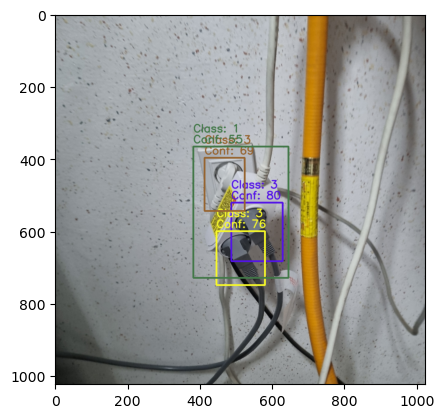

In [4]:
infer_start_time = time.time()

orig_image = cv2.imread('8.jpg')

image_height, image_width, _ = orig_image.shape
model_height, model_width = 300, 300
x_ratio = image_width/model_width
y_ratio = image_height/model_height


def load_image(path, g=1, pillow=True):
    im = Image.open(path)
    if pillow:
        im = ImageOps.exif_transpose(im)
    im = np.array(im, dtype=np.uint8)
    im = cv.cvtColor(im, cv.COLOR_RGB2BGR)
    if g == 0:
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    return im


def get_detections(v8_boxes):
    boxes = [] 
    for boxes_m in v8_boxes:     
        xyxy = boxes_m[:4]
        cls = boxes_m[-1]
        conf = boxes_m[-2]
        box1, box2, box3, box4 = xyxy[0], xyxy[1], xyxy[2], xyxy[3] 
        boxes.append([box1, box2, box3, box4, conf, cls])
    return boxes


def calculate_iou(box1, box2):

    x1, y1, w1, h1 = box1[:4]
    x2, y2, w2, h2 = box2[:4]

    w1, h1 = abs(x1 - w1), abs(y1 - h1)
    w2, h2 = abs(x2 - w2), abs(y2 - h2)

    intersection_x = max(x1, x2)
    intersection_y = max(y1, y2)
    intersection_w = max(0, min(x1 + w1, x2 + w2) - intersection_x)
    intersection_h = max(0, min(y1 + h1, y2 + h2) - intersection_y)

    intersection_area = intersection_w * intersection_h
    union_area = w1 * h1 + w2 * h2 - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0.0

    return iou


def get_boxes(results):
    boxes = results
    boxes = get_detections(boxes)
    return boxes


def print_boxes(boxes):
    class_names = ['wall_socket', 'extension', 'socket', 'power_plug', 'main_switch', 'UN_power_plug']
    for box in boxes:
        print(f"{class_names[int(box[-1])]}: {box[-2]}")


def classifier(detection_boxes):
    if len(detection_boxes) > 0:
        the_walls = []
        the_extensions = []
        for box in detection_boxes:
            if int(box[-1]) == 0:
                the_walls.append(box[4])
            if int(box[-1]) == 1:
                the_extensions.append(box[4])
        if len(the_extensions) > 0:
            return 'EXTENSION'
        if len(the_walls) > 0:
            return 'WALL'
        return 'NOTHING'
    return 'NOTHING'


def filter_boxes(boxes, classification):
    if classification in ['EXTENSION']:
        return filter_extensions(boxes)
    return boxes


def filter_extensions(boxes):
    others_without_UN = [box for box in boxes if int(box[-1]) not in [0, 1, 5]]
    unplugged = [box for box in boxes if int(box[-1]) == 5]
    extensions = [box for box in boxes if int(box[-1]) == 1]
    others = others_without_UN + unplugged
    if len(extensions) > 1:
        extensions = [extensions[np.argmax(np.array([box[-2] for box in extensions]))]]
    if len(others_without_UN) > 0:
        others_without_UN = [x for x in others_without_UN if calculate_iou(x[:4], extensions[0][:4]) != 0]
        others = others_without_UN + unplugged
        others = filter_boxes_by_iou(others, iou_threshold=0.8)
    return extensions + others


def final_classifier(all_boxes):
    image_type = classifier(detection_boxes=all_boxes)
    filtered_boxes = filter_boxes(boxes=all_boxes, classification=image_type)
    return apply_poc_rules_kor(filtered_boxes, image_type)


def filter_boxes_by_iou(boxes, iou_threshold):
    filtered_boxes = []
    for i, box_i in enumerate(boxes):
        if i in filtered_boxes:
            continue
        keep = True
        for j, box_j in enumerate(boxes):
            if i != j and box_i[4] != box_j[4]:
                iou = calculate_iou(box_i[:4], box_j[:4])
                if iou > iou_threshold:
                    keep = box_i[4] > box_j[4]
                    if not keep:
                        filtered_boxes.append(i)
                    break
        if keep:
            filtered_boxes.append(box_i)
    return [boxes[i] for i in range(len(boxes)) if i not in filtered_boxes]

def apply_poc_rules_kor(boxes, type_):
    s = len([x for x in boxes if int(x[-1]) == 2])  # socket
    p = len([x for x in boxes if int(x[-1]) == 3])  # power_plug
    m = len([x for x in boxes if int(x[-1]) == 4])  # main_switch
    u = len([x for x in boxes if int(x[-1]) == 5])  # unplugged

    total = p + s

    if type_ in ['NOTHING']:
        if u > 0:
            return '준수', f"전원선 분리"  # 전원선 분리된 모습 촬영
        return '미준수', f"전원선 확인 불가"

    if type_ in ['WALL']:
        if s > 0 and p + u == 0:
            return '미준수', f"전원선 확인 불가"
        return '준수', "벽면콘센트"

    if type_ in ['EXTENSION']:
        with_main_switch = '' if m == 0 else ' (메인스위치 있음)'
        if total == 2:
            with_main_switch = ' (메인스위치 없음)' if m == 0 else ' (메인스위치 있음)'

        if u > 0:
            return '준수', f"전원선 분리"

        if total == 1:
            if p == 1:
                return '준수', f"{total}구이상 멀티탭 전원선 1개 연결" + with_main_switch
            return '미준수', f"{total}구이상 멀티탭 전원선 {p}개 이상 연결" + with_main_switch

        if total > 1:
            if p == 1:
                return '준수', f"{total}구이상 멀티탭 전원선 1개 연결" + with_main_switch
            if p == 2:
                if m > 0 and s == 0:
                    return '준수', f"{total}구이상 멀티탭 전원선 {p}개 이상 연결" + with_main_switch
                return '미준수', f"{total}구이상 멀티탭 전원선 {p}개 이상 연결" + with_main_switch
            return '미준수', f"{total}구이상 멀티탭 전원선 {p}개 이상 연결" + with_main_switch
        return '미준수', f"{total}구이상 멀티탭 전원선 {p}개 이상 연결" + with_main_switch
    

def draw_bbox(result): 
    if 'boxes' in result:
        for idx,(x1,y1,x2,y2,conf,lbl) in enumerate(result['boxes']):
            x1, x2 = int(x_ratio*x1), int(x_ratio*x2)
            y1, y2 = int(y_ratio*y1), int(y_ratio*y2)
            color = (random.randint(10,255), random.randint(10,255), random.randint(10,255))
            cv2.rectangle(orig_image, (x1,y1), (x2,y2), color, 4)
            cv2.putText(orig_image, f"Class: {int(lbl)}", (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
            cv2.putText(orig_image, f"Conf: {int(conf*100)}", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

    

    
resized_image = cv2.resize(orig_image, (model_height, model_width))
payload = cv2.imencode('.jpg', resized_image)[1].tobytes()
result = predictor.predict(payload)
my_boxes = get_boxes(result['boxes'])



draw_bbox(result)
the_type = classifier(my_boxes)
the_boxes = filter_boxes(my_boxes, the_type)
result = apply_poc_rules_kor(the_boxes, the_type)
print('결과:', result)

infer_end_time = time.time()


print(f"추론시간 = {infer_end_time - infer_start_time:0.4f} sec")
plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
plt.show()

## 2.4 Cleanup by removing Endpoint, Endpoint Config and Model

In [5]:
response = sm_client.describe_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
print(response)
endpoint_config_name = response['EndpointConfigName']    

{'EndpointConfigName': 'yolov8-pytorch-2024-04-04-02-18-39-148488', 'EndpointConfigArn': 'arn:aws:sagemaker:ap-northeast-2:600996473339:endpoint-config/yolov8-pytorch-2024-04-04-02-18-39-148488', 'ProductionVariants': [{'VariantName': 'AllTraffic', 'ModelName': 'pytorch-inference-2024-04-04-02-18-43-440', 'InitialInstanceCount': 1, 'InstanceType': 'ml.t2.medium', 'InitialVariantWeight': 1.0}], 'CreationTime': datetime.datetime(2024, 4, 4, 11, 18, 44, 220000, tzinfo=tzlocal()), 'EnableNetworkIsolation': False, 'ResponseMetadata': {'RequestId': '77e28b82-f703-41c1-a0f8-9910a399e5ed', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '77e28b82-f703-41c1-a0f8-9910a399e5ed', 'content-type': 'application/x-amz-json-1.1', 'content-length': '444', 'date': 'Thu, 04 Apr 2024 02:32:29 GMT'}, 'RetryAttempts': 0}}


In [6]:
# Delete Endpoint
sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)

# Delete Endpoint Configuration
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

# Delete Model
for prod_var in response['ProductionVariants']:
    model_name = prod_var['ModelName']
    sm_client.delete_model(ModelName=model_name) 